## **Network Analysis of City Networks and Hospital Data**

Analysis of C2C and C2H networks.

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text, inspect, MetaData

from tqdm import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
from itertools import product
import datetime as dt
from collections import defaultdict, Counter

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress

import nxviz as nv
import networkx as nx
from networkx.algorithms import bipartite
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

import matplotlib
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma"]

basepath = Path.home().joinpath("Documents", "data")
netpath = basepath.joinpath("regulacao", "edgelists")

c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sesa\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


### **Functions**

In [49]:
def create_network(edgelist_df, net_type="c2c"):
    '''
    
    '''
    # -- default (c2c)
    if net_type=="c2c":
        source_nm, target_nm = "MUNIC_RES", "MUNIC_MOV" 
        graph = nx.DiGraph()
    elif net_type=="c2h":
        source_nm, target_nm = "MUNIC_RES", "CNES"
        graph = nx.DiGraph()
    elif net_type=="h2d":
        source_nm, target_nm = "CNES", "DIAG_CATEG"
        graph = nx.Graph() 
    elif net_type=="h2hs":
        source_nm, target_nm = "CNES", "SP_ATOPROF"
        graph = nx.Graph()
    elif net_type=="equip2hospital":
        source_nm, target_nm = "EQUIP_KEY", "CNES"
        graph = nx.Graph()
    elif net_type=="equip2mun":
        source_nm, target_nm = "EQUIP_KEY", "MUNIC_MOV"
        graph = nx.Graph()
    else:
        raise Exception("type not included.")  
        
    # Iterate through the dataframe and add edges with all edge attributes
    for idx, row in edgelist_df.iterrows():
        node_res = row[source_nm]
        node_mov = row[target_nm]
    
        # Get the edge attributes (all columns except the first two)
        edge_attributes = row.drop([source_nm, target_nm]).to_dict()
    
        # Add the edge with its attributes
        graph.add_edge(node_res, node_mov, **edge_attributes)
    return graph

def summarize_network(G, return_summary=True):
    summary = {}

    # Basic information
    summary['Number of Nodes'] = G.number_of_nodes()
    summary['Number of Edges'] = G.number_of_edges()
    summary['Is Directed'] = G.is_directed()
    summary['Is Bipartite'] = bipartite.is_bipartite(G)

    # Node and edge metadata keys
    if len(G.nodes) > 0:
        summary['Node Metadata Keys'] = list(next(iter(G.nodes(data=True)))[1].keys())
    else:
        summary['Node Metadata Keys'] = []

    if len(G.edges) > 0:
        summary['Edge Metadata Keys'] = list(next(iter(G.edges(data=True)))[2].keys())
    else:
        summary['Edge Metadata Keys'] = []

    # Degree information
    if G.is_directed():
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        summary['Mean In-Degree'] = sum(in_degrees.values()) / len(in_degrees)
        summary['Mean Out-Degree'] = sum(out_degrees.values()) / len(out_degrees)
    else:
        degrees = dict(G.degree())
        summary['Mean Degree'] = sum(degrees.values()) / len(degrees)

    # Printing summary
    for key, value in summary.items():
        print(f"{key}: {value}")

    if return_summary:
        return summary
    
def log_binning(degree_sequence, num_bins=50):
    degree_counts = Counter(degree_sequence)
    degrees, counts = zip(*degree_counts.items())
    degrees = np.array(degrees)
    counts = np.array(counts)

    # Define bins in log space
    min_degree = np.log10(min(degrees))
    max_degree = np.log10(max(degrees))
    bins = np.logspace(min_degree, max_degree, num=num_bins)

    # Bin the data
    binned_degrees = []
    binned_counts = []
    for i in range(len(bins) - 1):
        mask = (degrees >= bins[i]) & (degrees < bins[i + 1])
        if np.sum(mask) > 0:
            binned_degrees.append(np.sqrt(bins[i] * bins[i + 1]))
            binned_counts.append(np.sum(counts[mask]))

    return np.array(binned_degrees), np.array(binned_counts)

In [50]:
def perform_query(query_str, engine, batchsize=1000):

    schema_data = {
        'rows': [],
        'columns': [],
    }

    query_str = text(query_str)
    with engine.connect() as conn:
        qres = conn.execute(query_str)
        schema_data['columns'] = list(qres.keys())

        while True:
            rows = qres.fetchmany(batchsize)
            if not rows:
                break
            schema_data["rows"] += [ row for row in rows ]
    
    res_df = pd.DataFrame(schema_data['rows'], columns=schema_data['columns'])
    return res_df

### **C2C networks**

In [8]:
people_edgelist = pd.read_parquet(netpath.joinpath("c2c", "c2c_diag_people_2015_2017.parquet")).reset_index()
money_edgelist = pd.read_parquet(netpath.joinpath("c2c", "c2c_diag_money_2015_2017.parquet")).reset_index()
service_edgelist = pd.read_parquet(netpath.joinpath("c2c", "c2c_service_2015_2017.parquet")).reset_index()

# -- only one state
state_uf = "23"
people_edgelist = people_edgelist[(people_edgelist["MUNIC_RES"].str.contains("^23", regex=True)) & (people_edgelist["MUNIC_MOV"].str.contains("^23", regex=True))]
money_edgelist = money_edgelist[(money_edgelist["MUNIC_RES"].str.contains("^23", regex=True)) & (money_edgelist["MUNIC_MOV"].str.contains("^23", regex=True))]
service_edgelist = service_edgelist[(service_edgelist["MUNIC_RES"].str.contains("^23", regex=True)) & (service_edgelist["MUNIC_MOV"].str.contains("^23", regex=True))]


# -- generate the networks
net_people = create_network(people_edgelist, net_type='c2c')
net_money = create_network(money_edgelist, net_type='c2c')
net_service = create_network(service_edgelist, net_type='c2c')

# -- generate the networks without self-loops
people_edgelist1 = people_edgelist[~(people_edgelist["MUNIC_RES"]==people_edgelist["MUNIC_MOV"])]
money_edgelist1 = money_edgelist[~(money_edgelist["MUNIC_RES"]==money_edgelist["MUNIC_MOV"])]
service_edgelist1 = service_edgelist[~(service_edgelist["MUNIC_RES"]==service_edgelist["MUNIC_MOV"])]

# -- generate the networks
net_people_noself = create_network(people_edgelist1, net_type='c2c')
net_money_noself = create_network(money_edgelist1, net_type='c2c')
net_service_noself = create_network(service_edgelist1, net_type='c2c')

print("With Self Loops:\n")
print('C2C People:\n')
summarize_network(net_people, return_summary=False)
print('C2C Money:\n')
summarize_network(net_money, return_summary=False)
print('C2C Services:\n')
summarize_network(net_service, return_summary=False)

print("No Self Loops:\n")
print('C2C People:\n')
summarize_network(net_people_noself, return_summary=False)
print('C2C Money:\n')
summarize_network(net_money_noself, return_summary=False)
print('C2C Services:\n')
summarize_network(net_service_noself, return_summary=False)

With Self Loops:

C2C People:

Number of Nodes: 184
Number of Edges: 2273
Is Directed: True
Is Bipartite: False
Node Metadata Keys: []
Edge Metadata Keys: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'A30', 'A31', 'A32', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A46', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A56', 'A57', 'A58', 'A59', 'A60', 'A63', 'A64', 'A65', 'A66', 'A68', 'A69', 'A74', 'A77', 'A79', 'A80', 'A81', 'A82', 'A83', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A98', 'A99', 'B00', 'B01', 'B02', 'B03', 'B05', 'B06', 'B07', 'B08', 'B09', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B30', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49', 'B50', 'B51', 'B53', 'B54', 'B55', 'B57

#### **Topology and Weights**

**Degree Distribution**

2 183


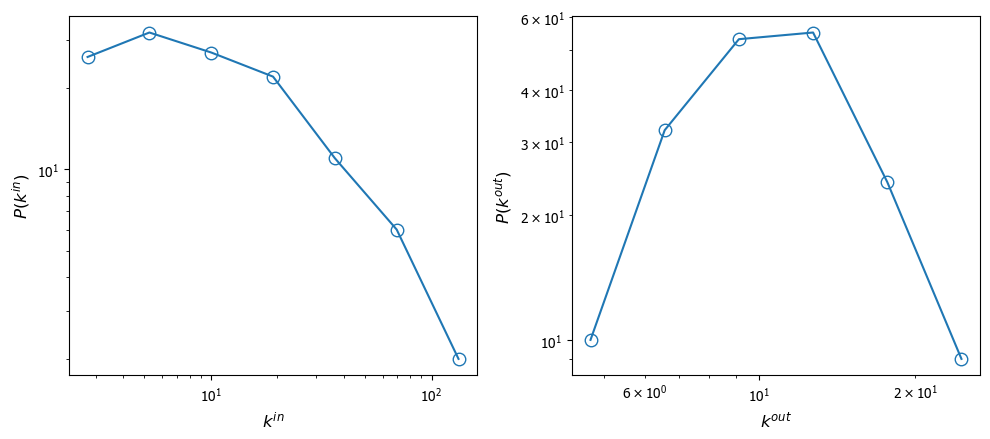

In [41]:
in_deg_sequence = [ elem for elem in list(dict(net_people_noself.in_degree()).values()) if elem>1 ] 
out_deg_sequence = [ elem for elem in list(dict(net_people_noself.out_degree()).values()) if elem>1 ]

in_deg_bins, in_binned_count = log_binning(in_deg_sequence, num_bins=8)
out_deg_bins, out_binned_count = log_binning(out_deg_sequence, num_bins=10)
print(min(in_deg_sequence), max(in_deg_sequence))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4.5))

ax1.plot(in_deg_bins, in_binned_count, ls='-', marker='o', ms=9, mfc='none')
ax2.plot(out_deg_bins, out_binned_count, ls='-', marker='o', ms=9, mfc='none')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax1.set_xlabel(r'$k^{in}$', fontsize=12)
ax2.set_xlabel(r'$k^{out}$', fontsize=12)
ax1.set_ylabel(r'$P(k^{in})$', fontsize=12)
ax2.set_ylabel(r'$P(k^{out})$', fontsize=12)

fig.tight_layout()

**Strength Distribution**

2.0 204862.0


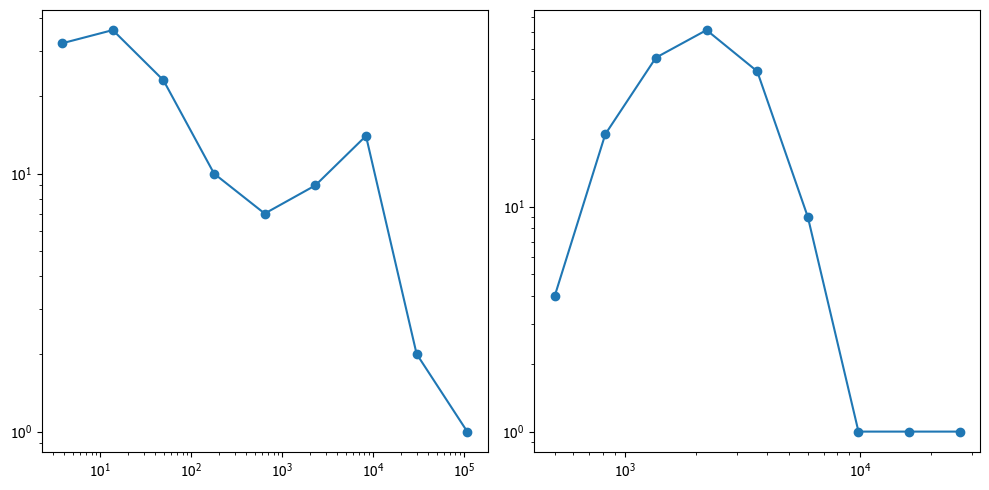

In [46]:
in_strength = [ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in net_people_noself.in_edges(node, data=True)) for node in net_people.nodes()}.values() ) if elem>1 ]
out_strength = [ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in net_people_noself.out_edges(node, data=True)) for node in net_people.nodes()}.values() ) if elem>1 ]

in_strength_bins, in_binned_count = log_binning(in_strength, num_bins=10)
out_strength_bins, out_binned_count = log_binning(out_strength, num_bins=10)

print(min(in_strength), max(in_strength))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(in_strength_bins, in_binned_count, ls='-', marker='o')
ax2.plot(out_strength_bins, out_binned_count, ls='-', marker='o')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

#ax1.set_xlim([10**0, 10**2.5])
#ax2.set_xlim([10**0, 10**2.5])
#ax1.set_ylim([10**0, 10**2])
#ax2.set_ylim([10**0, 10**2])

fig.tight_layout()

**Strength vs Degree**

In [ ]:
in_strength = [ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in net_people.in_edges(node, data=True)) for node in net_people.nodes()}.values() ) if elem>0 ]

In [5]:
people_edgelist[people_edgelist["MUNIC_RES"]==people_edgelist["MUNIC_MOV"]]

DIAG_CATEG,MUNIC_RES,MUNIC_MOV,A00,A01,A02,A03,A04,A05,A06,A07,...,Z90,Z91,Z92,Z93,Z94,Z96,Z97,Z98,Z99,SOMA
434,230020,230020,0.0,0.0,0.0,0.0,14.0,39.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6926.0
447,230030,230030,0.0,2.0,4.0,0.0,72.0,174.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3860.0
466,230040,230040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,186.0
483,230060,230060,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380.0
489,230070,230070,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,775.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,231380,231380,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188.0
2653,231390,231390,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0
2667,231395,231395,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357.0
2685,231400,231400,1.0,0.0,2.0,0.0,49.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7111.0


In [50]:
deg_bins

array([  1.14709786,   1.98610564,   3.43877865,   4.52486013,
         5.95396253,   7.83442334,  10.30879666,  13.56465997,
        17.84883396,  23.48609361,  30.9037887 ,  40.66424036,
        53.5073696 ,  70.40678927, 121.90356765])

array([17, 21, 19, 23,  2, 14, 14, 17,  9,  6,  9,  4,  4,  3,  2])

### **C2H networks**

### **CNES data**

#### **Query functions**

In [129]:
def quant_leitos_per_cnes(date, engine):
    '''
        Do not consider the type of the hospital bed.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    q = f'''
        SELECT
            a.*,
            b.CODUFMUN
        FROM (
            SELECT 
                CNES, SUM(QT_EXIST) as QUANT_LEITOS, SUM(QT_SUS) as QUANT_LEITOS_SUS 
            FROM leitos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000'
            GROUP BY CNES
        ) a
        LEFT JOIN cnes b
        ON a.CNES = b.CNES
    '''
    df = perform_query(q, engine).sort_values(by="QUANT_LEITOS", ascending=False)
    return df

def quant_leitos_per_mun(date, engine):
    '''
        Do not consider the type of the hospital bed.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    q = f'''
        SELECT
            CODUFMUN, SUM(QUANT_LEITOS) as QUANT_LEITOS,
            SUM(QUANT_LEITOS_SUS) as QUANT_LEITOS_SUS
        FROM (
            SELECT
                a.*, b.CODUFMUN
            FROM (
                SELECT 
                    CNES, SUM(QT_EXIST) as QUANT_LEITOS, SUM(QT_SUS) as QUANT_LEITOS_SUS 
                FROM leitos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000'
                GROUP BY CNES
            ) a
            LEFT JOIN cnes b
            ON a.CNES = b.CNES
        )
        GROUP BY CODUFMUN
    '''
    df = perform_query(q, engine).sort_values(by="QUANT_LEITOS", ascending=False)
    return df

def quant_equip_per_cnes(date, engine):
    '''
        Do not consider the type of the equipament.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    q = f'''
        SELECT
            a.*,
            b.CODUFMUN
        FROM (
            SELECT 
                CNES, SUM(QT_EXIST) as QUANT_EQUIP
            FROM equipamentos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000' AND IND_SUS = 1
            GROUP BY CNES
        ) a
        LEFT JOIN cnes b
        ON a.CNES = b.CNES
    '''
    df = perform_query(q, engine)
    return df

def quant_equip_per_mun(date, engine, ind_sus=True):
    '''
        Do not consider the type of the equipament.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    ind_sus_v = 1
    if not ind_sus:
        ind_sus_v = 0
    q = f'''
        SELECT
            CODUFMUN, SUM(QUANT_EQUIP) as QUANT_EQUIP
        FROM (
            SELECT
                a.*, b.CODUFMUN
            FROM (
                SELECT 
                    CNES, SUM(QT_EXIST) as QUANT_EQUIP
                FROM equipamentos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000' AND IND_SUS = {ind_sus_v}
                GROUP BY CNES
            ) a
            LEFT JOIN cnes b
            ON a.CNES = b.CNES
        )
        GROUP BY CODUFMUN
    '''
    df = perform_query(q, engine)
    return df

In [106]:
dicpath = Path.home().joinpath("Documents", "data", "opendatasus", "cnes")
leitos_dicionario_df = pd.read_excel(dicpath.joinpath("SCNES_DOMINIOS.xls"), sheet_name='LEITOS')
equip_dicionario_df = pd.read_excel(dicpath.joinpath("SCNES_DOMINIOS.xls"), sheet_name='EQUIPAMENTOS')

In [108]:
equip_dicionario_df.head(4)

,EQUIPAMENTO,DESCRIÇÃO,TIPO,DESCRIÇÃO.1
0,1,GAMA CAMARA,1,EQUIPAMENTOS DE DIAGNOSTICO POR IMAGEM
1,2,MAMOGRAFO COM COMANDO SIMPLES,1,EQUIPAMENTOS DE DIAGNOSTICO POR IMAGEM
2,3,MAMOGRAFO COM ESTEREOTAXIA,1,EQUIPAMENTOS DE DIAGNOSTICO POR IMAGEM
3,4,RAIO X ATE 100 MA,1,EQUIPAMENTOS DE DIAGNOSTICO POR IMAGEM


#### **Runnings**

In [119]:
# -- connect with the CNES database
dbpath = Path.home().joinpath("Documents", "data", "opendatasus")
cnes_name = "CNES_NORDESTE.db"

cnes_engine_url = f"sqlite:///{dbpath.joinpath(cnes_name)}"
cnes_engine = create_engine(cnes_engine_url)

# -- access test
q = f'''
    SELECT * FROM cnes LIMIT 5
'''
df = perform_query(q, cnes_engine)
df.head(4)

,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,VINC_SUS,TPGESTAO,ESFERA_A,NATUREZA,TP_UNID,NIV_HIER,TP_PREST,LATITUDE,LONGITUDE
0,2793970,270890,57120000,00000000000000,3,1,M,03,01,02,01,50,None,None
1,2005255,270030,57312620,00000000000000,3,1,M,03,01,02,03,50,None,None
2,2010453,270550,57820000,00000000000000,3,1,M,03,01,22,02,50,None,None
3,2008572,270010,57490000,00000000000000,3,1,M,03,01,01,01,50,None,None


In [130]:
date = dt.date(2010,1,1)
cnes_leitos_df = quant_leitos_per_cnes(date, cnes_engine)
cnes_equip_df = quant_equip_per_cnes(date, cnes_engine)
mun_leitos_df = quant_leitos_per_mun(date, cnes_engine)
mun_equip_df = quant_equip_per_mun(date, cnes_engine)

In [131]:
mun_equip_df

,CODUFMUN,QUANT_EQUIP
0,210005,65
1,210010,2
2,210015,4
3,210020,8
4,210030,16
...,...,...
1788,293330,698
1789,293340,20
1790,293345,6
1791,293350,58


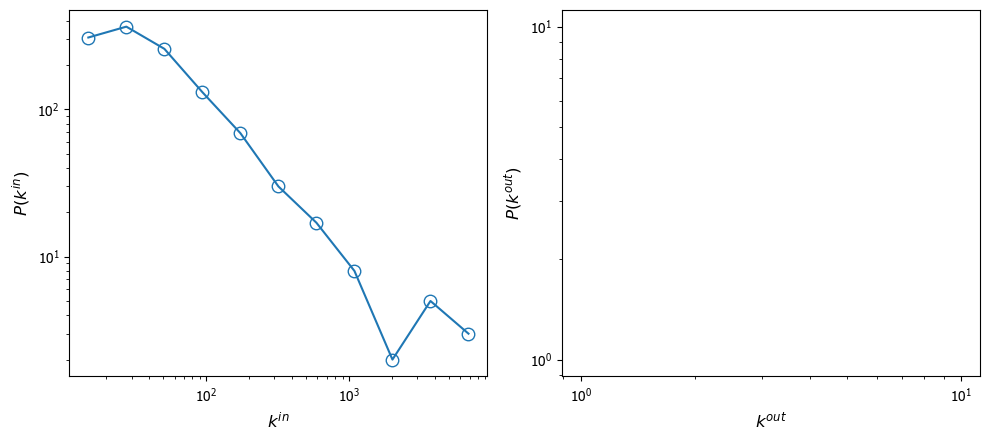

In [141]:
in_deg_sequence = [ elem for elem in mun_leitos_df['QUANT_LEITOS'].values if elem > 10 ]

in_deg_bins, in_binned_count = log_binning(in_deg_sequence, num_bins=12)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4.5))

ax1.plot(in_deg_bins, in_binned_count, ls='-', marker='o', ms=9, mfc='none')
#ax2.plot(out_deg_bins, out_binned_count, ls='-', marker='o', ms=9, mfc='none')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax1.set_xlabel(r'$k^{in}$', fontsize=12)
ax2.set_xlabel(r'$k^{out}$', fontsize=12)
ax1.set_ylabel(r'$P(k^{in})$', fontsize=12)
ax2.set_ylabel(r'$P(k^{out})$', fontsize=12)

fig.tight_layout()